In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from google.colab.patches import cv2_imshow 

In [3]:
import albumentations as A

In [4]:
train_data = pd.read_csv("train_csv.csv")
train_data.head()

label_name  bbox_x  bbox_y  bbox_width  bbox_height  \
0       page      50      60         437          632   
1       page      98     179         319          492   
2       page      35      76         839         1110   
3       page      73      60         437          597   
4       page     156      43         350          520   

                             image_name  image_width  image_height  
0  02af60962b84d32d757ac7784faa23fe.jpg          546           729  
1  08a776c9ad5f2ff6fb59993526ab2b59.jpg          564           705  
2  0d3f7d70bb98011f75862b1472d15c96.jpg          933          1244  
3  11e597a4e8430f17f51ea82a52dc6d05.jpg          564           765  
4  154c89ddf3257d40a712a2a427dc8625.jpg          563           603

In [5]:
train_data["x_max"] = train_data["bbox_x"] + train_data["bbox_width"]
train_data["y_max"] = train_data["bbox_y"] + train_data["bbox_height"]

In [6]:
train_data.rename(columns = {"bbox_y" : "y_min"}, inplace = True)
train_data.rename(columns = {"bbox_x" : "x_min"}, inplace = True)

In [7]:
train_data

label_name  x_min  y_min  bbox_width  bbox_height  \
0        page     50     60         437          632   
1        page     98    179         319          492   
2        page     35     76         839         1110   
3        page     73     60         437          597   
4        page    156     43         350          520   
..        ...    ...    ...         ...          ...   
83       page     59     51         618          870   
84       page     75     79         526          914   
85       page      9      8         133          191   
86       page      8      8         133          191   
87       page     16     14         223          304   

                                           image_name  image_width  \
0                02af60962b84d32d757ac7784faa23fe.jpg          546   
1                08a776c9ad5f2ff6fb59993526ab2b59.jpg          564   
2                0d3f7d70bb98011f75862b1472d15c96.jpg          933   
3                11e597a4e8430f17f51ea82a52dc6d05.jpg          564   
4                154c89ddf3257d40a712a2a427dc8625.jpg          563   
..                                                ...          ...   
83               ff44dde8a05968b163ea84bd39fc3f02.jpg          736   
84                  fullsizeoutput_54fc-682x1024.jpeg          682   
85  iiif-service_vhp_0320_032004_pm0005002-full-pc...          149   
86  iiif-service_vhp_0320_032004_pm0005003-full-pc...          148   
87  iiif-service_vhp_0320_032004_pm0006001-full-pc...          256   

    image_height  x_max  y_max  
0            729    487    692  
1            705    417    671  
2           1244    874   1186  
3            765    510    657  
4            603    506    563  
..           ...    ...    ...  
83           981    677    921  
84          1024    601    993  
85           209    142    199  
86           207    141    199  
87           334    239    318  

[88 rows x 10 columns]

In [8]:
def image_withbox(img_array, boxes):
     
     x      = boxes[0][0]
     y      = boxes[0][1]
     width  = boxes[0][2] - boxes[0][0]
     height = boxes[0][3] - boxes[0][1] 
     
     plt.figure(figsize = (8 ,10))
     img = plt.imshow(img_array)
     rect = img.axes.add_patch(plt.Rectangle((x, y), width, height, 
                                                  linewidth = 3, edgecolor = "r", fill = False))
     plt.show()


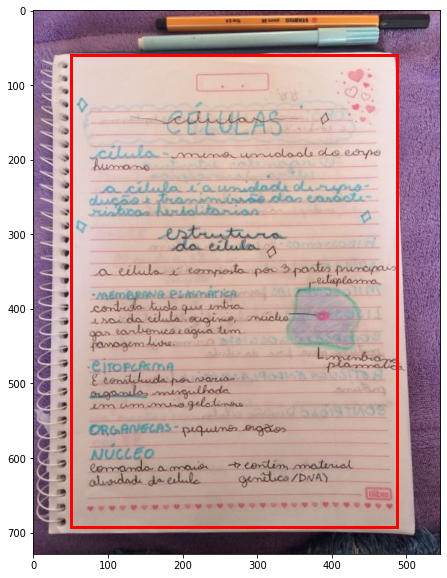

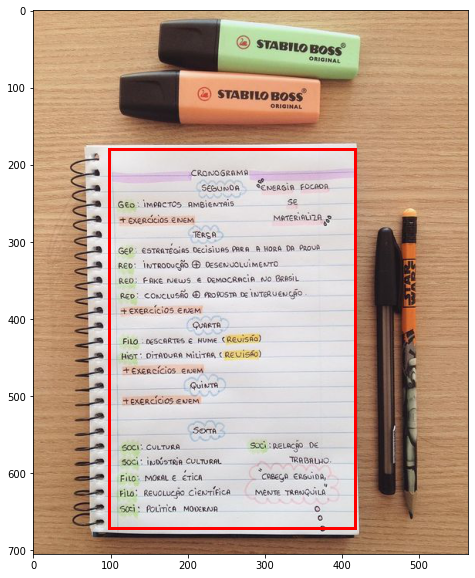

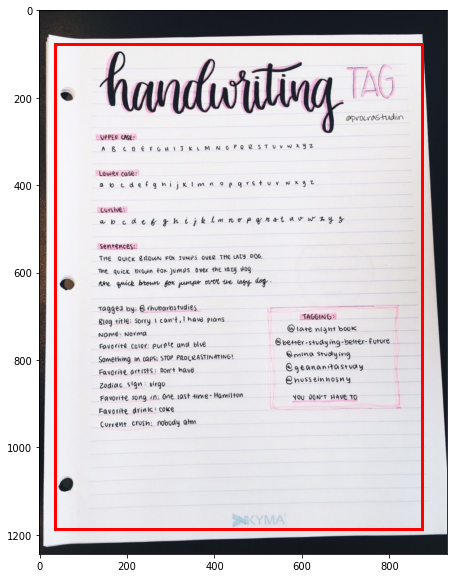

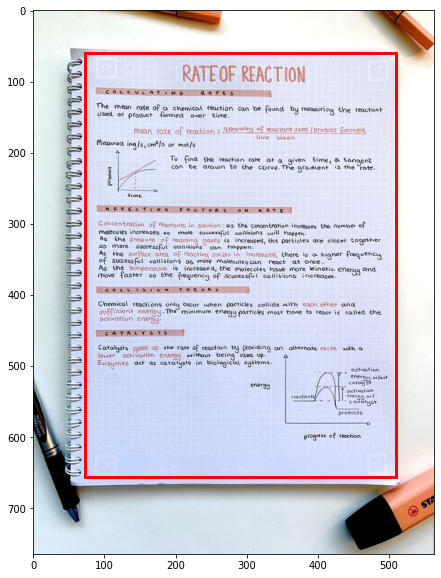

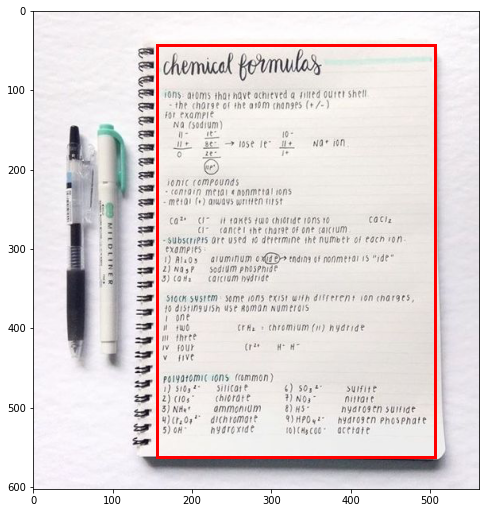

In [9]:
for x, y in train_data.head().iterrows():
    image_name = y["image_name"]
    image_path = f"/content/data_set_yolo/images/train/{image_name}"
    boxes = [(y["x_min"], y["y_min"], y["x_max"], y["y_max"])]
    
    train_image = keras.preprocessing.image.load_img(image_path)    
    np_image = keras.preprocessing.image.img_to_array(train_image)
    np_image = np_image.astype("uint8")
    
    image_withbox(np_image, boxes)

In [11]:
TARGET_HEIGHT = 224
TARGET_WIDTH  = 224

In [12]:
train_data.head()

label_name  x_min  y_min  bbox_width  bbox_height  \
0       page     50     60         437          632   
1       page     98    179         319          492   
2       page     35     76         839         1110   
3       page     73     60         437          597   
4       page    156     43         350          520   

                             image_name  image_width  image_height  x_max  \
0  02af60962b84d32d757ac7784faa23fe.jpg          546           729    487   
1  08a776c9ad5f2ff6fb59993526ab2b59.jpg          564           705    417   
2  0d3f7d70bb98011f75862b1472d15c96.jpg          933          1244    874   
3  11e597a4e8430f17f51ea82a52dc6d05.jpg          564           765    510   
4  154c89ddf3257d40a712a2a427dc8625.jpg          563           603    506   

   y_max  
0    692  
1    671  
2   1186  
3    657  
4    563

In [13]:
train_images = []
train_labels = []

test_images = []
test_labels = []

In [14]:
def normalize_labels(df):
  
    x_min = df["x_min"] / df["image_width"] 
    x_max = df["x_max"] / df["image_width"] 

    y_min = df["y_min"] / df["image_height"] 
    y_max = df["y_max"] / df["image_height"]

    return x_min, y_min, x_max, y_max

In [15]:
x_min, y_min, x_max , y_max = normalize_labels(train_data)

In [16]:
train_labels = []
for x1, y1, x2, y2 in zip(x_min, y_min, x_max, y_max):
    train_labels.append((x1, y1, x2, y2))
   

In [17]:
train_labels 

[(0.09157509157509157,
  0.0823045267489712,
  0.891941391941392,
  0.9492455418381345),
 (0.17375886524822695,
  0.25390070921985813,
  0.7393617021276596,
  0.9517730496453901),
 (0.03751339764201501,
  0.06109324758842444,
  0.9367631296891747,
  0.9533762057877814),
 (0.12943262411347517,
  0.0784313725490196,
  0.9042553191489362,
  0.8588235294117647),
 (0.27708703374777977,
  0.07131011608623548,
  0.8987566607460036,
  0.9336650082918739),
 (0.09574468085106383, 0.225, 0.8173758865248227, 0.975),
 (0.09042553191489362,
  0.06304985337243402,
  0.9202127659574468,
  0.9281524926686217),
 (0.05851063829787234,
  0.09707446808510638,
  0.9414893617021277,
  0.8191489361702128),
 (0.08156028368794327,
  0.09296148738379814,
  0.8705673758865248,
  0.8857901726427623),
 (0.042119565217391304,
  0.07849133537206932,
  0.967391304347826,
  0.9317023445463812),
 (0.23268206039076378,
  0.1954674220963173,
  0.7957371225577264,
  0.8739376770538244),
 (0.1095890410958904,
  0.0883333333

In [18]:
train_images = []
for x , y in train_data.iterrows():
    
    image_path = f"/content/data_set_yolo/images/train/{y[5]}"

    train_image = keras.preprocessing.image.load_img(image_path, target_size = (TARGET_HEIGHT, TARGET_WIDTH))
    
    img_array = keras.preprocessing.image.img_to_array(train_image)

    img_array = img_array.astype("uint8")

    train_images.append(img_array)

In [19]:
print(len(train_images))

88


In [20]:

flip_transform = A.Compose([
      A.Resize(height=TARGET_HEIGHT, width=TARGET_WIDTH),    
     A.HorizontalFlip(p = 1.0)],
     bbox_params = A.BboxParams(
          format="pascal_voc",
          label_fields=["class_labels"],
    ))

In [21]:
image_path = "/content/data_set_yolo/images/train/08a776c9ad5f2ff6fb59993526ab2b59.jpg"

train_image = keras.preprocessing.image.load_img(image_path)

np_image = keras.preprocessing.image.img_to_array(train_image)
np_image = np_image.astype("uint8")

In [22]:
boxes = [(98, 179, 417, 671)]

In [23]:
flip_transform_result = flip_transform(
    image=np_image, bboxes=boxes, class_labels=[0])

fliped_image = flip_transform_result["image"]
fliped_boxes = flip_transform_result["bboxes"]

In [24]:
fliped_boxes[0]

(58.38297872340425, 56.87375886524822, 185.07801418439718, 213.19716312056738)

In [25]:
fliped_boxes[0][0]

58.38297872340425

In [26]:
fliped_image.dtype

dtype('uint8')

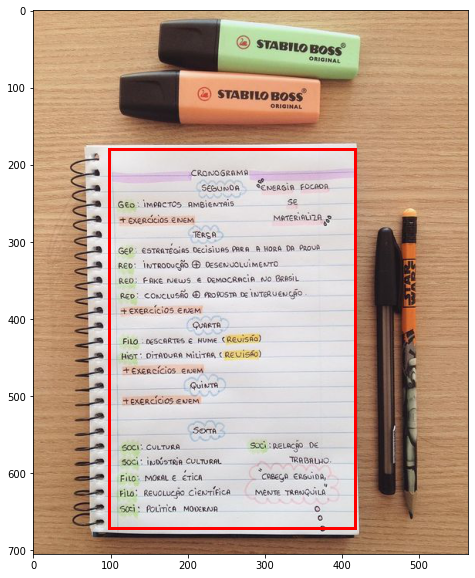

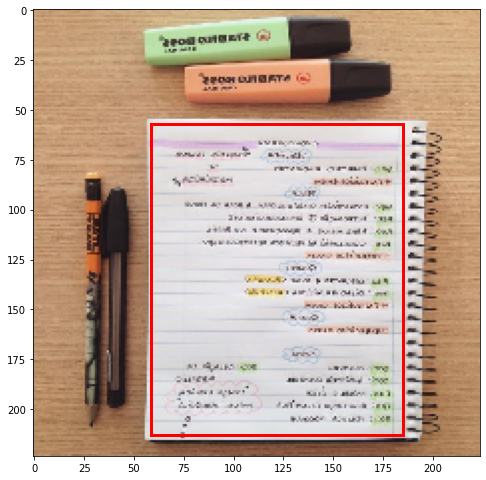

In [28]:
image_withbox(np_image, boxes)
image_withbox(fliped_image, fliped_boxes)

In [29]:
for x, y in train_data.iterrows():
    image_path = f"/content/data_set_yolo/images/train/{y[5]}"

    train_image = keras.preprocessing.image.load_img(image_path)
    
    img_array = keras.preprocessing.image.img_to_array(train_image)
    
    boxes = [(y["x_min"], y["y_min"], y["x_max"], y["y_max"])]
    np_image = img_array.astype("uint8")

    flip_transform_result = flip_transform(
                           image=np_image, bboxes=boxes, class_labels=[0])

    fliped_image = flip_transform_result["image"]
    fliped_boxes = flip_transform_result["bboxes"]

    x1 = fliped_boxes[0][0] / TARGET_WIDTH
    y1 = fliped_boxes[0][1] / TARGET_HEIGHT

    x2 = fliped_boxes[0][2] / TARGET_WIDTH
    y2 = fliped_boxes[0][3] / TARGET_HEIGHT
    
    train_images.append(fliped_image)
    train_labels.append((x1, y1, x2, y2))
    

In [31]:
len(train_images)

176

In [32]:
len(train_labels)

176

In [33]:
test_data = pd.read_csv("test_csv.csv")
test_data

label_name  bbox_x  bbox_y  bbox_width  bbox_height  \
0        page      83     110         394          565   
1        page      74     108         432          613   
2        page      26     199         500          701   
3        page      29     147         567          803   
4        page      38     134         502          728   
5        page      26      32         480          684   
6        page      76      69         331          464   
7        page       3     148         744         1035   
8        page      20      35         537          704   
9        page      98     126         326          560   
10       page      12      19         665          937   
11       page      61      33         354          510   
12       page      64      57         424          581   
13       page      67     153         663          968   
14       page     108      71         352          507   
15       page      68      85         433          622   
16       page       5     177         544          721   
17       page      33      77         330          443   
18       page      50      93         305          407   
19       page      13     133         511          739   
20       page     100      70         368          529   
21       page      29      24         506          721   
22       page      10       8         132          191   
23       page      16      14         225          303   

                                           image_name  image_width  \
0                021594948ac5ad15213b33e4b0b5d8ca.jpg          564   
1                058eeccda566ce0132bd7a2ffe3f5272.jpg          564   
2                0dfdab88d57631ac52ffd2ea4f93ebf3.jpg          564   
3                      2017-02-20_14-28-05_586079.jpg          666   
4                28f834b7ffc34dc224f7c63fa09a5a13.jpg          564   
5                2a083758f00fb20dfa4c1e39ee84c947.jpg          563   
6                                               4.jpg          458   
7                49094b33f157c649c35ec73fd2e1955a.jpg          750   
8                7e8f9fd41c4f63abd2dd77d5bd5e3b85.jpg          563   
9                84e2e49baff493d27824bf6cb6d15f15.jpg          564   
10               a04d3c8a1ba53e3d47902156cf5cce53.jpg          736   
11               a10f9b6d83b5ea377b539fa068f264dc.jpg          564   
12               b6fe41fa0aa8b08e1f28d071e1f8432c.jpg          564   
13               b887b56006626c0555aa5397fd4ed520.jpg          750   
14               c1a7f7d13f72a2fb92d06c184a9fe89c.jpg          554   
15               d363abd3e5dadb083c9bd9ed0d6e1b3c.jpg          564   
16               d610e097553a70e48e62757f81c112ec.jpg          564   
17  depositphotos_19575561-stock-photo-white-canva...          400   
18  depositphotos_7318267-stock-photo-white-paper-...          400   
19               efd305a9a8ebed89aaff8c9b4a181337.jpg          564   
20               f224ff3dc4cf74b281946b6c404414f6.jpg          546   
21               f4efd330c124089e81fef1b7192705cb.jpg          564   
22  iiif-service_vhp_0320_032004_pm0005001-full-pc...          150   
23  iiif-service_vhp_0320_032004_pm0006002-full-pc...          256   

    image_height  
0            752  
1            848  
2           1002  
3           1000  
4           1002  
5            751  
6            600  
7           1333  
8            751  
9            752  
10           981  
11           564  
12           752  
13          1333  
14           738  
15           752  
16          1053  
17           600  
18           600  
19          1002  
20           729  
21           752  
22           208  
23           334

In [34]:
test_data["x_max"] = test_data["bbox_x"] + test_data["bbox_width"]
test_data["y_max"] = test_data["bbox_y"] + test_data["bbox_height"]

test_data.rename(columns = {"bbox_y" : "y_min"}, inplace = True)
test_data.rename(columns = {"bbox_x" : "x_min"}, inplace = True)

In [36]:
for x , y in test_data.iterrows():
    
    image_path = f"/content/data_set_yolo/images/val/{y[5]}"
    test_image = keras.preprocessing.image.load_img(image_path, target_size = (TARGET_HEIGHT, TARGET_WIDTH))
    img_array = keras.preprocessing.image.img_to_array(test_image)
    img_array = img_array.astype("uint8")
    test_images.append(img_array)

In [37]:
x_min, y_min, x_max , y_max = normalize_labels(test_data)

In [38]:
for x1, y1, x2, y2 in zip(x_min, y_min, x_max, y_max):
    test_labels.append((x1, y1, x2, y2))

In [40]:
len(test_labels)

24

In [41]:
len(test_images)

24

In [42]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [43]:
train_images.shape

(176, 224, 224, 3)

In [44]:
Input = (TARGET_HEIGHT, TARGET_WIDTH, 3)
input_layer = tf.keras.layers.Input(Input)

In [45]:
base_layers = layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)

In [46]:
#locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(base_layers)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

In [47]:
model = tf.keras.Model(input_layer , outputs = [locator_branch])

In [48]:
from tensorflow.python.keras.callbacks import TensorBoard

In [49]:
from time import time

In [50]:
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [51]:
losses = {"bb_head":tf.keras.losses.MSE}

In [52]:
model.compile(loss=losses, optimizer='Adam',  metrics=["accuracy"] )


In [53]:
trainTargets = {
    
    "bb_head": train_labels
}
validationTargets = {
    
    "bb_head": test_labels
}

In [54]:
training_epochs = 600

In [55]:
train_images.shape

(176, 224, 224, 3)

In [56]:
history = model.fit(train_images, trainTargets,
             validation_data=(test_images, validationTargets),
             batch_size=4,
             epochs=training_epochs,
             shuffle=True,
             verbose=1)

Epoch 1/600
44/44 [==============================] - 8s 10ms/step - loss: 0.0158 - accuracy: 0.6080 - val_loss: 0.0076 - val_accuracy: 0.4167
Epoch 2/600
44/44 [==============================] - 0s 6ms/step - loss: 0.0047 - accuracy: 0.6136 - val_loss: 0.0052 - val_accuracy: 0.4167
Epoch 3/600
44/44 [==============================] - 0s 6ms/step - loss: 0.0025 - accuracy: 0.6136 - val_loss: 0.0031 - val_accuracy: 0.3333
Epoch 4/600
44/44 [==============================] - 0s 6ms/step - loss: 0.0021 - accuracy: 0.6136 - val_loss: 0.0025 - val_accuracy: 0.3333
Epoch 5/600
44/44 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.6875 - val_loss: 0.0023 - val_accuracy: 0.5417
Epoch 6/600
44/44 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.7443 - val_loss: 0.0024 - val_accuracy: 0.4167
Epoch 7/600
44/44 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.6364 - val_loss: 0.0019 - val_accuracy: 0.5833
Epoch 8/600


In [57]:
def get_pascalformat(boxes, height, width):
    
    prediction = boxes
    x1 = int(round(((prediction[0][0] * width))))
    y1 = int(round(((prediction[0][0] * height))))

    x2 = int(round(((prediction[0][2] * width))))
    y2 = int(round(((prediction[0][3] * height))))

    return [x1, y1, x2, y2]

In [58]:
def croped_image(img_path, boxes):
      
    img = plt.imread(img_path)

    height , width, __ = img.shape
    
    boxes = get_pascalformat(boxes, height, width)

    img_cropped = img[boxes[1] : boxes[3], boxes[0] : boxes[2]]

    plt.figure(figsize = (15, 15))
    return plt.imshow(img_cropped)
    
    



In [59]:
def Predict(img_path):
    
    train_image = keras.preprocessing.image.load_img(img_path, target_size = (TARGET_HEIGHT, TARGET_WIDTH))

    img_array = keras.preprocessing.image.img_to_array(train_image)
    img_array = img_array.astype("uint8")
    img_array = img_array.reshape(1, 224, 224, 3)

    prediction = model.predict(img_array)
    print(prediction)
    
    return croped_image(img_path, prediction)


   

In [60]:
def Original_image(img_path):

     img = plt.imread(img_path)

     plt.imshow(img)




1/1 [==============================] - 0s 171ms/step
[[0.12139101 0.17379706 0.8752065  0.8940652 ]]


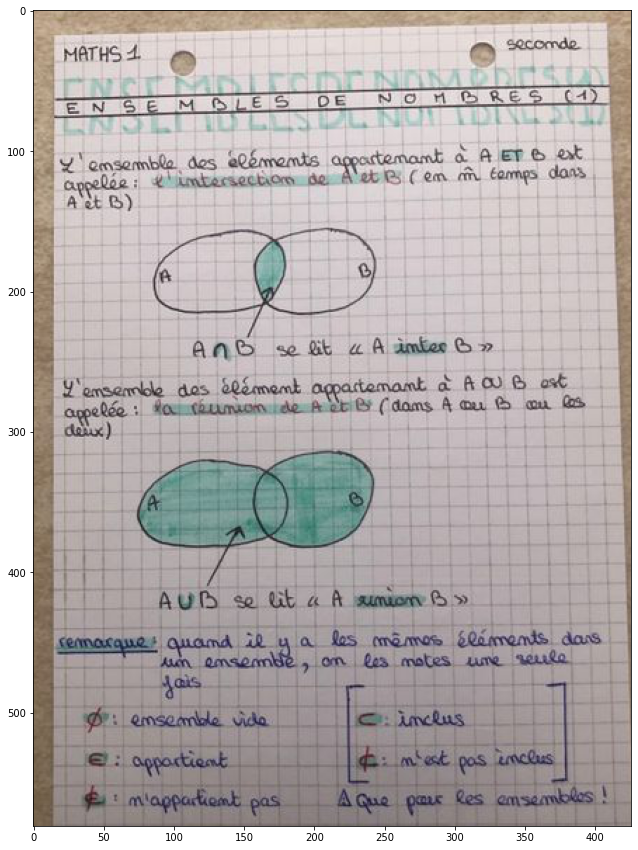

In [61]:
Predict("/content/data_set_yolo/images/val/021594948ac5ad15213b33e4b0b5d8ca.jpg")

1/1 [==============================] - 0s 14ms/step
[[0.11290022 0.16378528 0.89996725 0.8541843 ]]


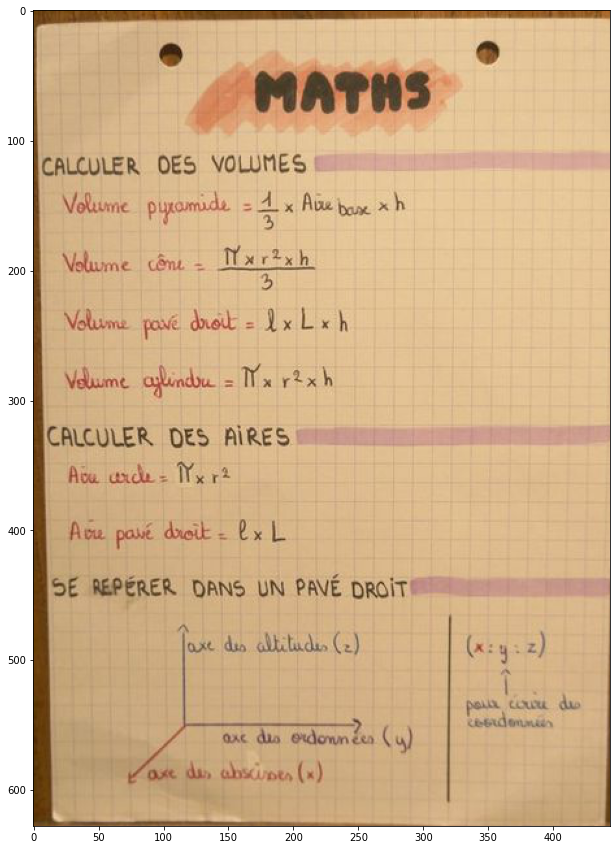

In [62]:
Predict("/content/data_set_yolo/images/val/058eeccda566ce0132bd7a2ffe3f5272.jpg")

1/1 [==============================] - 0s 16ms/step
[[0.07305916 0.10841542 0.94791394 0.8416409 ]]


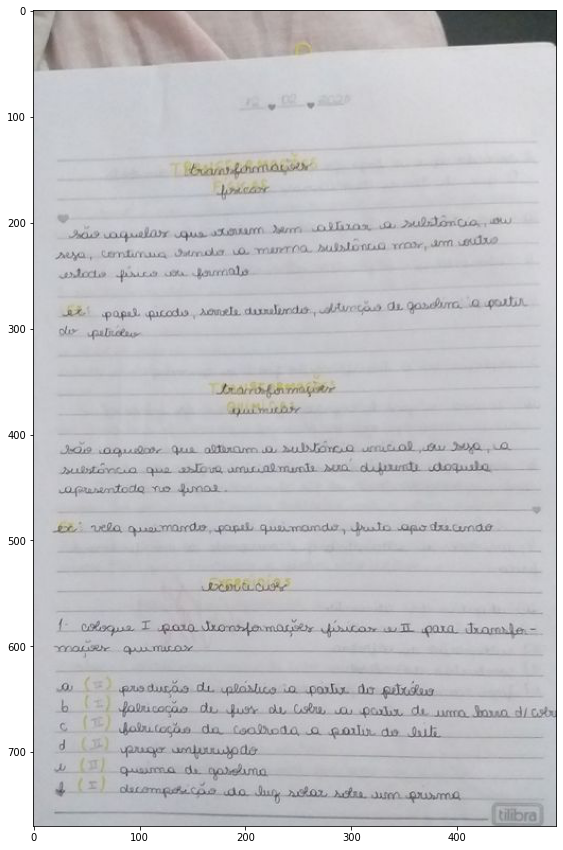

In [63]:
Predict("/content/data_set_yolo/images/val/28f834b7ffc34dc224f7c63fa09a5a13.jpg")

In [64]:
model.save("final_model.h5")